# Course: DD2424 - Assignment 1

In [126]:
import numpy as np
import _pickle as cPickle
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

### the gradients of the cost function for a mini-batch (both Soft-Max and SVM)

In [147]:
# compute the gradients of the cost function for a mini-batch
def ComputeGradients(X, Y, y, P, W, B, lamda, mode):
    if mode is 'softmax':
        g=np.zeros((1,len(y)))
        grad_b=0.
        grad_W=np.zeros(W.shape)
        for i in range(len(y)):
            yT=Y.T[i].reshape(1,len(Y.T[i]))
            p=P[:,i].reshape(len(P[:,i]),1)
            g=np.dot(yT/np.dot(yT,p),np.diag(P[:,i])-np.dot(p,p.T))
            grad_b-=g
            grad_W-=np.dot(g.T,X.T[i].reshape(1,len(X.T[i]))) 
        grad_W/=len(y)
        grad_b/=len(y)
        grad_W+= 2*lamda*W
        return grad_W, grad_b.T
        
    if mode is 'SVM':
        grad_W=np.zeros(W.shape)
        grad_b=np.zeros(B.shape)
        for i in range(len(y)):
            x=np.expand_dims(X[:,i],axis=1)
            s=(np.dot(W,x)+B).clip(0)
            g=(s[y[i]]-s - 1 <0)*1
            g[y[i]]=-(np.sum(g)-1)
            grad_b+=g
            grad_W+=np.dot(g,x.T)
        grad_W/=len(y)
        grad_b/=len(y)
        grad_W+= lamda*W
        return grad_W, grad_b
             

### the minibatch algithm

In [128]:
# the minibatch algithm
def MiniBatchGD(X, Y, y, GDparams, W, B, Vx, Vy, VY, mode):

    lossOnTrain=[]
    lossOnValidation=[]
    accuracyOnTrain=[]
    accuracyOnValidation=[]
    storedW=[]
    storedB=[]
    
    #Compute initial stats for thaining and validation set
    cost, loss = ComputeCost(X,Y,y,W,B,GDparams.lamda, mode)
    lossOnTrain.append(loss)
    cost, loss =ComputeCost(Vx,VY,Vy,W,B,GDparams.lamda, mode)
    lossOnValidation.append(loss)
    accuracyOnTrain.append(ComputeAccuracy(X, y, W, B,mode))
    accuracyOnValidation.append(ComputeAccuracy(Vx, Vy, W, B,mode))

    #start mini-batch
    for epoch in range(GDparams.n_epochs):
        i=0
        while i<len(X.T):
            ### create batch
            if i+GDparams.n_batch > len(y):
                Xbatch=X[:,i:len(y)]
            else:
                Xbatch=X[:,i:i+GDparams.n_batch]
            if i+GDparams.n_batch > len(y):
                Ybatch=Y[:,i:len(y)]
            else:
                Ybatch=Y[:,i:i+GDparams.n_batch] 
            if i+GDparams.n_batch > len(y):
                ybatch=y[i:len(y)]
            else:
                ybatch=y[i:i+GDparams.n_batch] 
                
            #-----> TRAIN BATCH ->            
            if mode is 'softmax': 
                #  -> go forward...
                batchEval=EvaluateClassifier(Xbatch, W, B)
                # <-... go backwards (compute the gradients)
                grad_W, grad_b=ComputeGradients(Xbatch, Ybatch, ybatch, batchEval, W,B, GDparams.lamda, mode)
                
            if mode is 'SVM':
                batchEval='None'
                grad_W, grad_b=ComputeGradients(Xbatch, Ybatch, ybatch, batchEval, W,B, GDparams.lamda, mode)
                
            # update the weights
            W= W - GDparams.eta * grad_W
            B= B - GDparams.eta * grad_b
            i+=GDparams.n_batch
            
        #set drop learing rate to on or off
        if DropRate=='on':
            GDparams.eta-=GDparams.eta-GDparams.eta*0.9
            
        #Compute stats for thaining and validation set durring learning
        
        cost, loss = ComputeCost(X,Y,y,W,B,GDparams.lamda,mode)
        lossOnTrain.append(loss)
        cost, loss =ComputeCost(Vx,VY,Vy,W,B,GDparams.lamda,mode)
        lossOnValidation.append(loss)
        accuracyOnTrain.append(ComputeAccuracy(X, y, W, B, mode))
        accuracyOnValidation.append(ComputeAccuracy(Vx, Vy, W, B, mode))
        
        #store the weights
        storedW.append(W)
        storedB.append(B)
        
        #set early stopping
        if EarlyStop is 'on' and epoch > 10 :
            TrackAcc=np.average(accuracyOnValidation[epoch-10:epoch])
            if TrackAcc > accuracyOnValidation[epoch+1]:
                break
            
    BestIter=np.argmax(accuracyOnValidation)
    
    
    return storedW[BestIter-1], storedB[BestIter-1], lossOnTrain, lossOnValidation, accuracyOnTrain, accuracyOnValidation, BestIter



### Other Functions

In [129]:
# the object for the parameters of the minibatch
class GDparams(object):
    def __init__(self, lamda, n_epochs, n_batch, eta):
        self.lamda=lamda
        self.n_epochs=n_epochs
        self.n_batch=n_batch
        self.eta=eta

# READ THE DATA function
def LoadBatch(filename):
    #read the data from a CIFAR-10 batch file and return the image and label data in separate files
    #this function is adopted from the source: https://github.com/PaddlePaddle/Paddle/issues/1301

    f = open(filename, 'rb')
    d = cPickle.load(f, encoding='bytes')
    d_decoded = {}
    for k, v in d.items():
        d_decoded[k.decode('utf8')] = v
    d = d_decoded
    f.close()
    data = d['data']
    labels = d['labels']
    filenames = [b.decode("utf-8") for b in d['filenames']]

    return data, labels, filenames

# Convert to One Hot Representation
def OneHotRep(labels):
    oneHot=np.zeros((len(labels),np.max(labels)+1))
    oneHot[np.arange(len(labels)), labels] = 1
    
    return oneHot

# weight initialization
def weightInt(inNodes,outNodes, mode,PCnumber):
    if mode is 'random':
        W=np.random.normal(0,0.01,(outNodes,inNodes))
        b=np.random.normal(0,0.01,(outNodes,1))
    
    if mode is 'PCA':
        W=np.zeros((outNodes,inNodes))
        b=np.random.normal(0,0.01,(outNodes,1))
        for i in range(trainingSetLabels.max()+1):
            #find all data from the wanted class
            pos=np.where(trainingSetLabels == i)
            #aply PCA on the dataset and export the 1st component
            c=trainingSet.T[pos].T
            pca = PCA(PCnumber, 'full')
            DimRed = pca.fit_transform(c).T
            for comp in range(PCnumber):
                W[i]+=DimRed[comp]
        W=((W)/(np.abs(W.min())+W.max()))/100.
    return W,b

# forward the input to output through matrix multiplication with weights and the addition of bias
def fwd(X,W,b):
    s=np.dot(W,X)+b
    
    return s
   
# the SoftMax function
def SoftMax(s):
    probability=np.exp(s)/np.sum(np.exp(s),axis=0)
    
    return probability

# network function evaluation
def EvaluateClassifier(X, W, b):
    s=fwd(X,W,b)
    p=SoftMax(s)
    return p

#compute the SVM total loss
def SVMloss(s,y,W):
    loss=0.
    for i in range(len(s)):
        if i != y:
            loss+=np.maximum(0,s[i] - s[y] + 1).clip(0)
    return loss

# compute the cost function
def ComputeCost(X, Y,y, W, b, lamda, mode):
    if mode=='softmax':
        crossEntropy=np.diag(-np.log(np.dot(Y.T,EvaluateClassifier(X, W, b))))
    elif mode=='SVM':
        crossEntropy=0
        for i in range(len(y)):
            x=np.expand_dims(X[:,i],axis=1)
            s=np.dot(W,x)+b
            crossEntropy+=SVMloss(s,y[i],W)
    regularization = 0.5*lamda*np.sum(W**2)
    loss=np.sum(crossEntropy)/len(y)
    cost=crossEntropy + regularization
    
    return cost, loss

# compute the net's accuracy
def ComputeAccuracy(X, y, W, b,mode):
    if mode is 'softmax':
        k=np.argmax(EvaluateClassifier(X, W, b), axis=0)
    elif mode is 'SVM':
        NetEval = np.dot(W,X)+b
        k=np.argmax(NetEval,axis=0)
    diff=np.abs(k-y)
    accuracy=1-np.count_nonzero(diff)/len(y)
    return accuracy



#Search Grid for parameters lambda and eta
def GridSearch(X, Y, y, W, B, Vx, Vy, VY, mode,grid):
    LamdaGrid=grid
    EtaGrid=grid
    accuracy=np.zeros((LamdaGrid+1,EtaGrid+1))*np.nan
    GridLamda=np.arange(LamdaGrid+1)/LamdaGrid
    GridEta=(np.arange(EtaGrid+1)/EtaGrid)/100+0.005
    i=0
    for lamda in GridLamda:
        j=0
        for eta in GridEta:
            if lamda>=0 and eta>0:
                params=GDparams(lamda, 40, 100, eta)
                wTemp, bTemp, lossOnTrainTemp, lossOnValidationTemp, accuracyOnTrainTemp, \
                accuracyOnValidationTemp, bestIt = MiniBatchGD(X,Y, y, params,W, B, Vx, Vy, VY,'softmax')
                accuracy[i,j]=np.asarray(accuracyOnValidationTemp).max()
#                 print(lamda,eta,accuracy[i,j])
                j+=1
            else:
                j+=1
        i+=1
    
    bestLamdaIndex,bestEtaIndex=np.unravel_index(accuracy.argmax(),accuracy.shape)
    bestLamda=GridLamda[bestLamdaIndex]
    bestEta=GridEta[bestEtaIndex]
    bestValue=np.max(accuracy)
    
    LamdaGrid-=1
    EtaGrid-=1
    exGridLamda=np.arange(LamdaGrid+1)*0.01+bestLamda-(LamdaGrid/2)*0.01
    exGridEta=np.arange(EtaGrid+1)*0.001+bestEta-(EtaGrid/2)*0.001
    ExtaAccuracy=np.zeros((LamdaGrid+1,EtaGrid+1))#*np.nan

    if mode is 'extended':
        i=0
        for lamda in exGridLamda:
            j=0
            for eta in exGridEta:
                if lamda>=0 and eta>0:
                    params=GDparams(lamda, 40, 100, eta)
                    wTemp, bTemp, lossOnTrainTemp, lossOnValidationTemp, accuracyOnTrainTemp, \
                    ExtAccuracyOnValidationTemp, bestIt = MiniBatchGD(X,Y, y, params,W, B, Vx, Vy, VY)
                    ExtaAccuracy[i,j]=np.asarray(ExtAccuracyOnValidationTemp).max()
#                     print(lamda,eta,ExtaAccuracy[i,j])
                    j+=1
                else:
                    j+=1 
            i+=1
        ExtbestLamdaIndex,ExtbestEtaIndex=np.unravel_index(ExtaAccuracy.argmax(),ExtaAccuracy.shape)
        ExtBestLamda=GridLamda[ExtbestLamdaIndex]
        ExtBestEta=GridEta[ExtbestEtaIndex]
        ExtBestValue=np.max(ExtaAccuracy)

        if ExtBestValue>bestValue:
            bestLamda=ExtBestLamda
            bestEta=ExtBestEta
            bestValue=ExtBestValue
            
    paramsOpt=GDparams(bestLamda, 40, 100, bestEta)     
    wOpt, bOpt, lossOnTrainTemp, lossOnValidationTemp, accuracyOnTrainTemp, \
                    ExtAccuracyOnValidationTemp, bestIt = MiniBatchGD(X,Y, y, paramsOpt,W, B, Vx, Vy, VY)
    print('The best accuracy %s is retrieved with lamda=%s and eta=%s'%(bestValue*100,bestLamda,bestEta))   
    
    return wOpt,bOpt,bestLamda, bestEta, bestValue,accuracy,ExtaAccuracy

# compute analyticaly the gradients
def ComputeGradsNumSlow(X, Y, y, W, b, lamda, h, N, f, mode):
    # set features dimensionality
    W=W[:,:f]
    X=X[:f,:N]
    Y=Y[:,:N]
    y=y[:N]

    no=len(W)
    d=len(X)

    # initialize gradients
    grad_W=np.zeros(W.shape)
    grad_b=np.zeros((len(b),1))
    
    if mode is 'OneHot':
        # compute gradients for bias
        for i in range(len(b)):
            b_try = b
            b_try[i] -= h
            _,c1=ComputeCost(X, Y, W, b_try, lamda, mode)
            b_try = b
            b_try[i] += h
            _,c2=ComputeCost(X, Y, W, b_try, lamda, mode)
            grad_b[i] = (c2-c1) / (2*h);

        # compute gradients for bias
        for i in range(W.size):
            W_try = W
            W_try.flat[i] -= h
            _,c1=ComputeCost(X, Y, W_try, b, lamda, mode)
            W_try = W
            W_try.flat[i] += h
            _,c2=ComputeCost(X, Y, W_try, b, lamda, mode)
            grad_W.flat[i] = (c2-c1) / (2*h);
            
    elif mode is 'VecRep':
        # compute gradients for bias
        for i in range(len(b)):
            b_try = b
            b_try[i] -= h
            _,c1=ComputeCost(X, Y, W, b_try, lamda, mode)
            b_try = b
            b_try[i] += h
            _,c2=ComputeCost(X, Y, W, b_try, lamda, mode)
            grad_b[i] = (c2-c1) / (2*h);

        # compute gradients for bias
        for i in range(W.size):
            W_try = W
            W_try.flat[i] -= h
            _,c1=ComputeCost(X, y, W_try, b, lamda, mode)
            W_try = W
            W_try.flat[i] += h
            _,c2=ComputeCost(X, y, W_try, b, lamda, mode)
            grad_W.flat[i] = (c2-c1) / (2*h);
    
    return grad_W, grad_b


def GradsDiff(X, Y, y, diffParams, W, B, Vx, Vy, VY, N,f, h ):
    
    X_an=X[:f,:N]
    W_an=W[:,:f]
    Y_an=Y[:,:N]
    y_an=y[:N]
    
    # compute the gradients analyticaly
    i=0
    while i<len(X_an.T):
        ### create batch
        if i+diffParams.n_batch > len(y_an):
            Xbatch=X_an[:,i:len(y_an)]
        else:
            Xbatch=X_an[:,i:i+diffParams.n_batch]
        if i+diffParams.n_batch > len(y_an):
            Ybatch=Y_an[:,i:len(y_an)]
        else:
            Ybatch=Y_an[:,i:i+diffParams.n_batch] 
        netEval=EvaluateClassifier(Xbatch, W_an, B)
        grad_W_an, grad_b_an=ComputeGradients(Xbatch, Ybatch, netEval, W_an, diffParams.lamda, mode='serial')
        i+=diffParams.n_batch
        
    # compute the gradients numeracaly
    grad_W_num, grad_b_num = ComputeGradsNumSlow(X, Y, y, W, B, diffParams.lamda,\
                                     10**(-6), N, f, mode='OneHot')
    #compute the difference
    diffW=np.abs(grad_W_an-grad_W_num)/np.max((np.abs(grad_W_an)+np.abs(grad_W_num)+10**(-10)).clip(0))
    diffB=np.abs(grad_b_an-grad_b_num)/np.max((np.abs(grad_b_an)+np.abs(grad_b_num)+10**(-10)).clip(0))
    
    meanDiff=(diffW.mean()+diffB.mean())/2.

    return meanDiff  
    

# visualize the learning stats
def LearningStats(params,lossOnTrain,lossOnValidation,accuracyOnTrain,accuracyOnValidation,name):
    color1='r'
    color2='g'
    fig = plt.figure()
    #plot the loss
    ax = fig.add_subplot(1, 3, 1)
    ax.plot(lossOnTrain, label='Training Set')
    ax.plot(lossOnValidation,color2, label='Validation Set')
    ax.set_title('loss vs iter')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('loss')
    
     #plot the error rate
    ax = fig.add_subplot(1, 3, 2)
    errorOnTrain = [1-x for x in accuracyOnTrain]
    errorOnValidation = [1-x for x in accuracyOnValidation]
    ax.plot(errorOnTrain ,color1, label='Training Set')
    ax.plot(errorOnValidation,color2, label='Validation Set')
    ax.set_title('error vs iter')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('error')
    
    #plot accuracy
    ax = fig.add_subplot(1, 3, 3)
    ax.plot(accuracyOnTrain,color1, label='Training Set')
    ax.plot(accuracyOnValidation,color2, label='Validation Set')
    ax.set_title('accuracy vs iter')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('accuracy')
    plt.legend(bbox_to_anchor=(-1, 1), loc='upper left', ncol=1)
    
    plt.subplots_adjust(left=-1.2)
    # lamda, n_epochs, n_batch, eta 
    plt.savefig('results/LearningStats_lambda=%s_batch=%s_%s.png'\
                %(params.lamda,params.n_batch,name), bbox_inches='tight')
    plt.show()

    
# weight visualization
def VisWeights(w,params,name):
    images=[]
    for img in w:
        rawImage=np.rot90(img.reshape(32, 32, 3),-1)
        image=((rawImage-np.min(rawImage))/(np.max(rawImage)-np.min(rawImage)))
        images.append(image)

    fig = plt.figure(figsize=(20, 200))
    for idx in range(len(w)):
        ax = fig.add_subplot(1, 10, idx+1)
        ax.set_title('Class %s'%(idx+1))
        ax.imshow(images[idx])
        ax.axis('off')
    plt.savefig('results/WeightVisualization_lambda=%s_batch=%s_%s.png'\
                %(params.lamda,params.n_batch,name), bbox_inches='tight')
    plt.show()

## Load the Data Sets

In [3]:
# read batches
batch_1, labels_1, filenames_1=LoadBatch('cifar10\data_batch_1')
batch_1=(np.transpose(batch_1.reshape(len(batch_1),3,32,32), (0,3,2,1)).reshape(len(batch_1),32*32*3))
labels_hot_1=OneHotRep(labels_1)
batch_2, labels_2, filenames_2=LoadBatch('cifar10\data_batch_2')
batch_2=(np.transpose(batch_2.reshape(len(batch_2),3,32,32), (0,3,2,1)).reshape(len(batch_2),32*32*3))
labels_hot_2=OneHotRep(labels_2)
batch_3, labels_3, filenames_3=LoadBatch('cifar10\data_batch_3')
batch_3=(np.transpose(batch_3.reshape(len(batch_3),3,32,32), (0,3,2,1)).reshape(len(batch_3),32*32*3))
labels_hot_3=OneHotRep(labels_3)
batch_4, labels_4, filenames_4=LoadBatch('cifar10\data_batch_4')
batch_4=(np.transpose(batch_4.reshape(len(batch_4),3,32,32), (0,3,2,1)).reshape(len(batch_4),32*32*3))
labels_hot_4=OneHotRep(labels_4)
batch_5, labels_5, filenames_5=LoadBatch('cifar10\data_batch_5')
batch_5=(np.transpose(batch_5.reshape(len(batch_5),3,32,32), (0,3,2,1)).reshape(len(batch_5),32*32*3))
labels_hot_5=OneHotRep(labels_5)
test_batch, labels_test, filenames_test=LoadBatch('cifar10\\test_batch')
test_batch=(np.transpose(test_batch.reshape(len(test_batch),3,32,32), (0,3,2,1)).reshape(len(test_batch),32*32*3))
labels_hot_test=OneHotRep(labels_test)

#create the training set as float in the interval 0-1
trainingSet=np.transpose(batch_1/255.)
trainingSetLabels=np.transpose(labels_1)
trainingSetLabels_hot=np.transpose(labels_hot_1)

#create the validation set as float in the interval 0-1z
validationSet=np.transpose(batch_2/255.)
validationSetLabels=np.transpose(labels_2)
validationSetLabels_hot=np.transpose(labels_hot_2)

#Use all the available data
HugeSet=np.concatenate((batch_1,batch_2,batch_3,batch_4,batch_5))
HugeSetLabels=np.concatenate((labels_1,labels_2,labels_3,labels_4,labels_5))
HugeSetLabels_hot=np.concatenate((labels_hot_1,labels_hot_2,labels_hot_3,labels_hot_4,labels_hot_5))
HugetrainingSet=np.transpose(HugeSet/255.)
HugetrainingSetLabels=np.transpose(HugeSetLabels)
HugetrainingSetLabels_hot=np.transpose(HugeSetLabels_hot)
HugevalidationSet=np.transpose(test_batch/255.)
HugevalidationSetLabels=np.transpose(labels_test)
HugevalidationSetLabels_hot=np.transpose(labels_hot_test)

# initialize weights
wIn,bIn=weightInt(len(trainingSet),len(trainingSetLabels_hot),'random',1)
# w,b=weightInt(len(trainingSet),len(trainingSetLabels_hot),'PCA',1)


# Exercise 1 of the assignment 1
Batch_1 is training set, Batch_2 is validation set. BatchSize=100

The maximum accuracy on train set is: 39.57%
The maximum accuracy on validation set is: 32.88% at epoch No 39


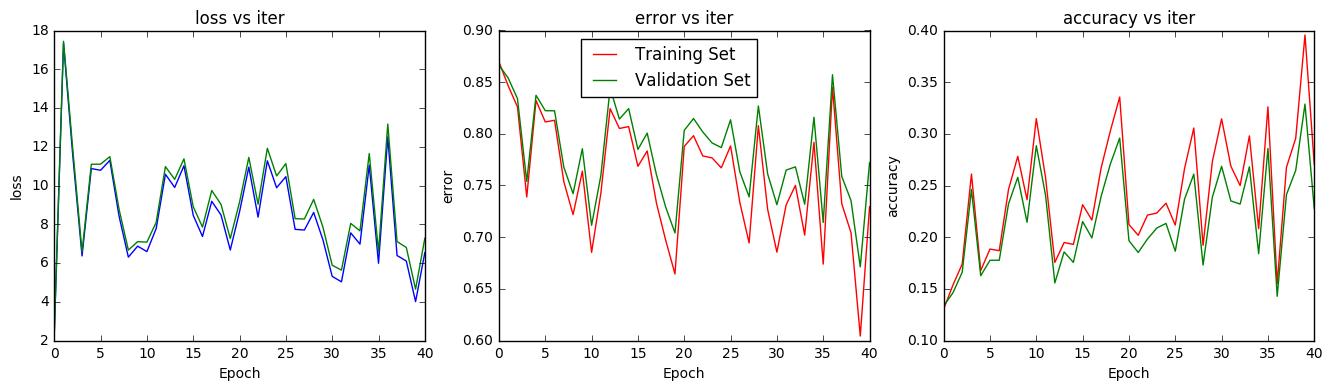

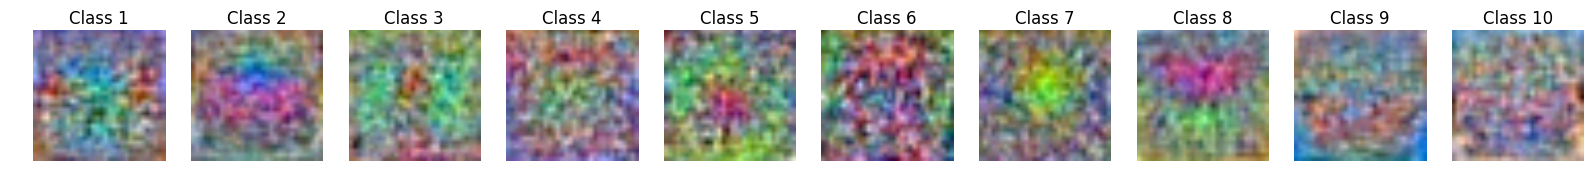

In [35]:
DropRate='off'
# give parmeters of the minibatch
# lamda, n_epochs, n_batch, eta 
params=GDparams(0, 40, 100, 0.01)
EarlyStop='off'
#train the net with minibatch



wSimple, bSimple, lossOnTrain, lossOnValidation, accuracyOnTrain, accuracyOnValidation, BestIter = MiniBatchGD(trainingSet, \
                                                         trainingSetLabels_hot, trainingSetLabels, params, \
                                                            wIn, bIn, validationSet, validationSetLabels, validationSetLabels_hot,\
                                                                                                               'softmax')

# print out learning accuracy
print("The maximum accuracy on train set is: %s"%(np.max(accuracyOnTrain)*100)+"%")
print("The maximum accuracy on validation set is: %s"%(np.max(accuracyOnValidation)*100)+"%"+" at epoch No %s"%BestIter)
# visualize the learing stats
LearningStats(params,lossOnTrain,lossOnValidation,accuracyOnTrain,accuracyOnValidation,'Simple')

# ## weight visualization
VisWeights(wSimple,params,'Simple')

# Exercise 2 of assingment 1

Use all the available training data for training. Decrease the size of the
validation set down to ~ 1000.

The maximum accuracy on train set is: 43.5368421053%
The maximum accuracy on validation set is: 37.3% at epoch No 100


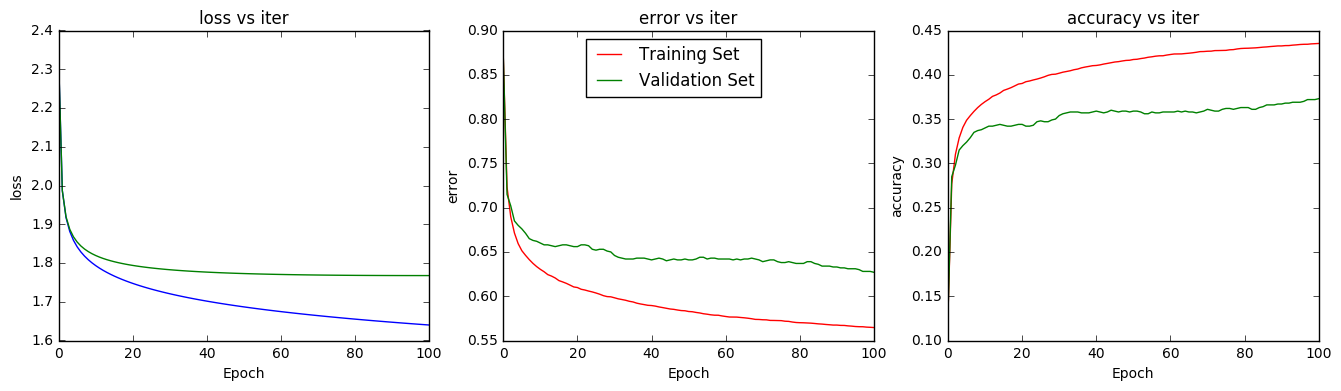

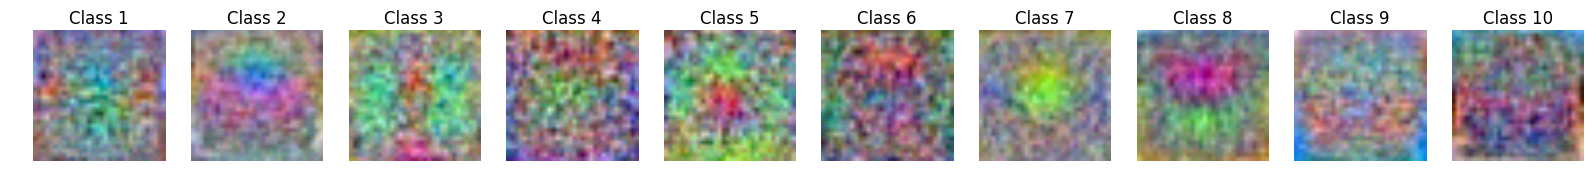

In [51]:
#set smaller validation set and increase the training one
ValSize=1000
trainingSetBig=np.concatenate((trainingSet.T,validationSet.T[:len(validationSet.T)-ValSize])).T
trainingSetLabelsBig=np.concatenate((trainingSetLabels,validationSetLabels[:len(validationSet.T)-ValSize]))
trainingSetLabels_hotBig=np.concatenate((trainingSetLabels_hot.T,validationSetLabels_hot.T[:len(validationSetLabels_hot.T)-ValSize])).T
validationSetSmall=validationSet[:,len(validationSet.T)-ValSize:]
validationSetLabelsSmall=validationSetLabels[len(validationSet.T)-ValSize:]
validationSetLabels_hotSmall=validationSetLabels_hot[:,len(validationSet.T)-ValSize:]

# initialize weights
# wBig,bBig=weightInt(len(trainingSet),len(trainingSetLabels_hot),'random',1)
# w,b=weightInt(len(trainingSet),len(trainingSetLabels_hot),'PCA',1)

# give parmeters of the minibatch
# lamda, n_epochs, n_batch, eta 
paramsBig=GDparams(0, 100, 100, 0.01)
EarlyStop='off'
DropRate='off'
#train the net with minibatch

wBig, bBig, lossOnTrainBig, lossOnValidationBig, accuracyOnTrainBig, accuracyOnValidationBig, BestIter = MiniBatchGD(trainingSetBig, \
                                                         trainingSetLabels_hotBig, trainingSetLabelsBig, paramsBig, \
                                                            wIn, bIn, validationSetSmall, validationSetLabelsSmall, validationSetLabels_hotSmall,'softmax')

# print out learning accuracy
print("The maximum accuracy on train set is: %s"%(np.max(accuracyOnTrainBig)*100)+"%")
print("The maximum accuracy on validation set is: %s"%(np.max(accuracyOnValidationBig)*100)+"%"+" at epoch No %s"%BestIter)
# visualize the learing stats
LearningStats(paramsBig,lossOnTrainBig,lossOnValidationBig,accuracyOnTrainBig,accuracyOnValidationBig,'BigTrainSet')

# ## weight visualization
VisWeights(wBig,paramsBig,'BigTrainSet')

Train for a longer time and use your validation set to make sure you don't
overfit or keep a record of the best model before you begin to overfit.

The maximum accuracy on train set is: 44.75%
The maximum accuracy on validation set is: 37.44% at epoch No 98


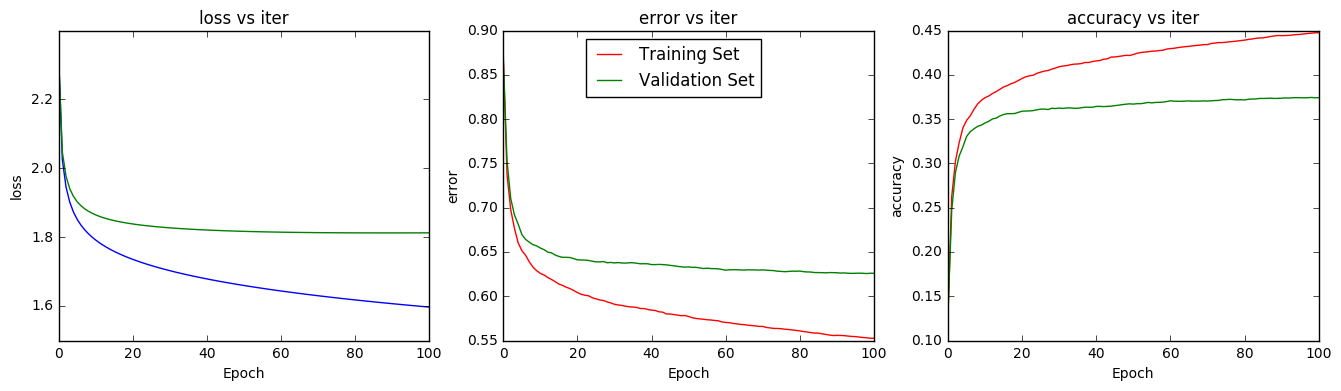

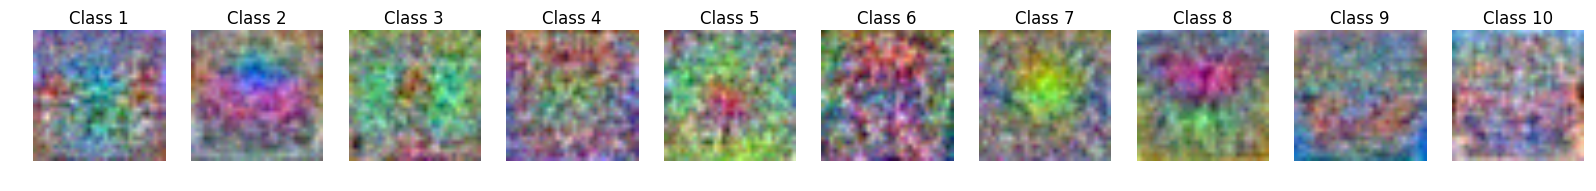

In [54]:
EarlyStop='on'
DropRate='off'
#set smaller validation set and increase the training one
ValSize=10000
trainingSetBig=np.concatenate((trainingSet.T,validationSet.T[:len(validationSet.T)-ValSize])).T
trainingSetLabelsBig=np.concatenate((trainingSetLabels,validationSetLabels[:len(validationSet.T)-ValSize]))
trainingSetLabels_hotBig=np.concatenate((trainingSetLabels_hot.T,validationSetLabels_hot.T[:len(validationSetLabels_hot.T)-ValSize])).T
validationSetSmall=validationSet[:,len(validationSet.T)-ValSize:]
validationSetLabelsSmall=validationSetLabels[len(validationSet.T)-ValSize:]
validationSetLabels_hotSmall=validationSetLabels_hot[:,len(validationSet.T)-ValSize:]

# initialize weights
# wBig,bBig=weightInt(len(trainingSet),len(trainingSetLabels_hot),'random',1)
# w,b=weightInt(len(trainingSet),len(trainingSetLabels_hot),'PCA',1)

# give parmeters of the minibatch
# lamda, n_epochs, n_batch, eta 
paramsBigEarly=GDparams(0, 100, 100, 0.01)

#train the net with minibatch

wBigEarly, bBigEarly, lossOnTrainBig, lossOnValidationBig, accuracyOnTrainBig, accuracyOnValidationBig, BestIter = \
                    MiniBatchGD(trainingSetBig,trainingSetLabels_hotBig, trainingSetLabelsBig, paramsBigEarly, \
                                wIn, bIn, validationSetSmall, validationSetLabelsSmall, validationSetLabels_hotSmall,'softmax')

# print out learning accuracy
print("The maximum accuracy on train set is: %s"%(np.max(accuracyOnTrainBig)*100)+"%")
print("The maximum accuracy on validation set is: %s"%(np.max(accuracyOnValidationBig)*100)+"%"+" at epoch No %s"%BestIter)
# visualize the learing stats
LearningStats(paramsBigEarly,lossOnTrainBig,lossOnValidationBig,accuracyOnTrainBig,accuracyOnValidationBig,'EarlyStop')

# ## weight visualization
VisWeights(wBigEarly,paramsBigEarly,'EarlyStop')


Do a grid search to find good values for the amount of regularization and the
learning rate

The best accuracy 37.38 is retrieved with lamda=0.0 and eta=0.006


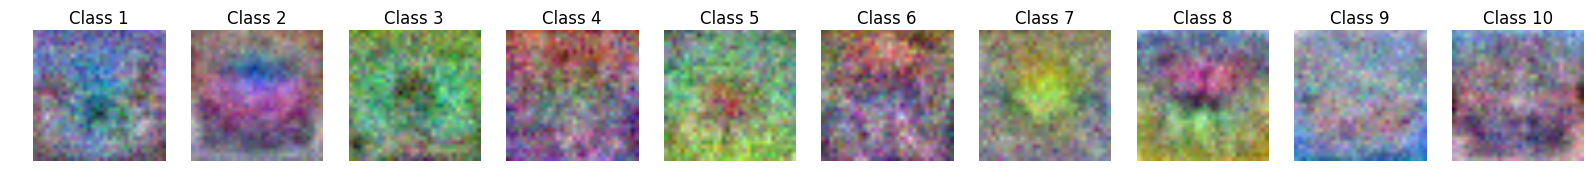

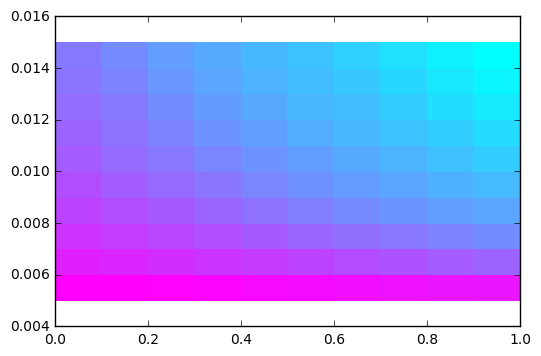

In [7]:
EarlyStop='off'
DropRate='off'
gridSize=10
#Grid search for optimal values of lamda and eta
# wOpt,bOpt=weightInt(len(trainingSet),len(trainingSetLabels_hot),'random',1)          
wOpt,bOpt,bestLamda, bestEta, bestValue, accuracy,ExtaAccuracy=\
            GridSearch(trainingSet,trainingSetLabels_hot, trainingSetLabels, \
                wIn, bIn, validationSet, validationSetLabels, validationSetLabels_hot,'NOTextended',gridSize)

# ## weight visualization
VisWeights(wOpt,GDparams(bestLamda, 20, 100, bestEta),'GridSearch')

# visualize grid
GridLamda=np.arange(gridSize+1)/gridSize
GridEta=(np.arange(gridSize+1)/gridSize)/100+0.005
# Plot a basic wireframe.
plt.pcolor(GridLamda, GridEta, accuracy, cmap='cool')
plt.savefig('results/GridEvalParams.png', bbox_inches='tight')
plt.show()

Play around with decaying the learning rate by a factor ~ 0.9 after each epoch.
Or you can decay the learning rate by a factor of 10 after n epochs.

The maximum accuracy on train set is: 40.41%
The maximum accuracy on validation set is: 36.76%


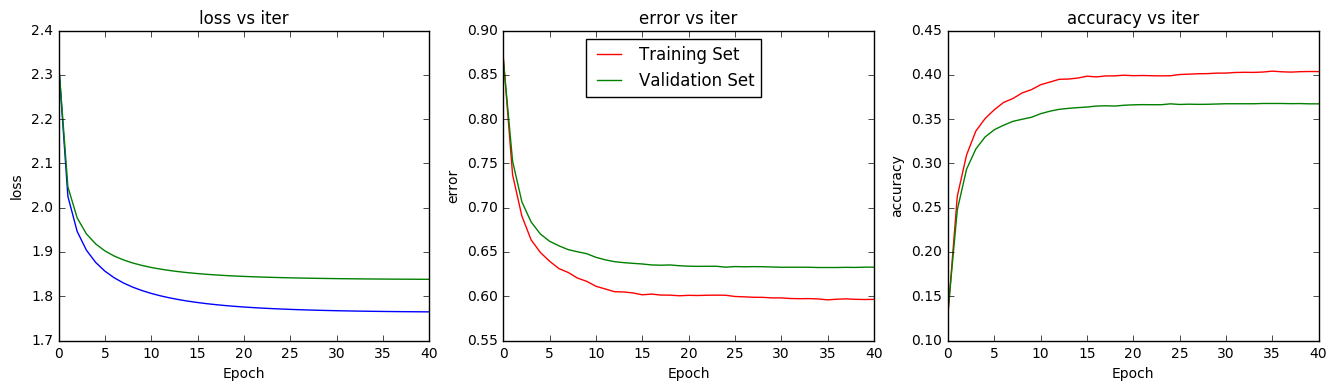

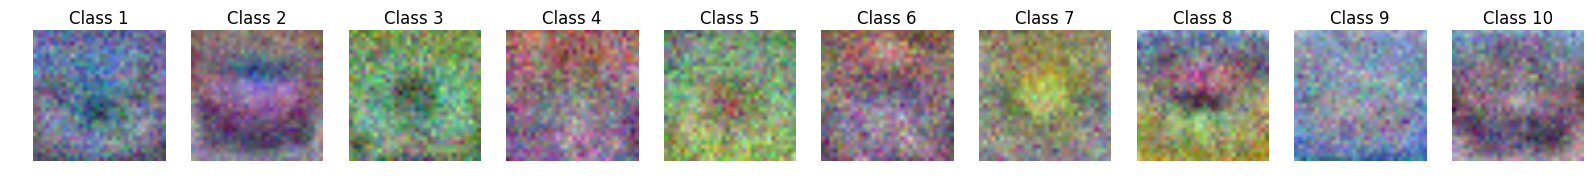

In [55]:
DropRate='on'
# give parmeters of the minibatch
# lamda, n_epochs, n_batch, eta 
params=GDparams(0, 40, 100, 0.01)
EarlyStop='off'
#train the net with minibatch


wDropRate, bDropRate, lossOnTrain, lossOnValidation, accuracyOnTrain, accuracyOnValidation, BestIter = MiniBatchGD(trainingSet, \
                                                         trainingSetLabels_hot, trainingSetLabels, params, \
                                                            wIn, bIn, validationSet, validationSetLabels, validationSetLabels_hot,'softmax')

# print out learning accuracy
print("The maximum accuracy on train set is: %s"%(np.max(accuracyOnTrain)*100)+"%")
print("The maximum accuracy on validation set is: %s"%(np.max(accuracyOnValidation)*100)+"%")
# visualize the learing stats
LearningStats(params,lossOnTrain,lossOnValidation,accuracyOnTrain,accuracyOnValidation,'DropRate')

# ## weight visualization
VisWeights(wDropRate,params,'DropRate')

Best example

The maximum accuracy on train set is: 40.34%
The maximum accuracy on validation set is: 36.78% at epoch No 34


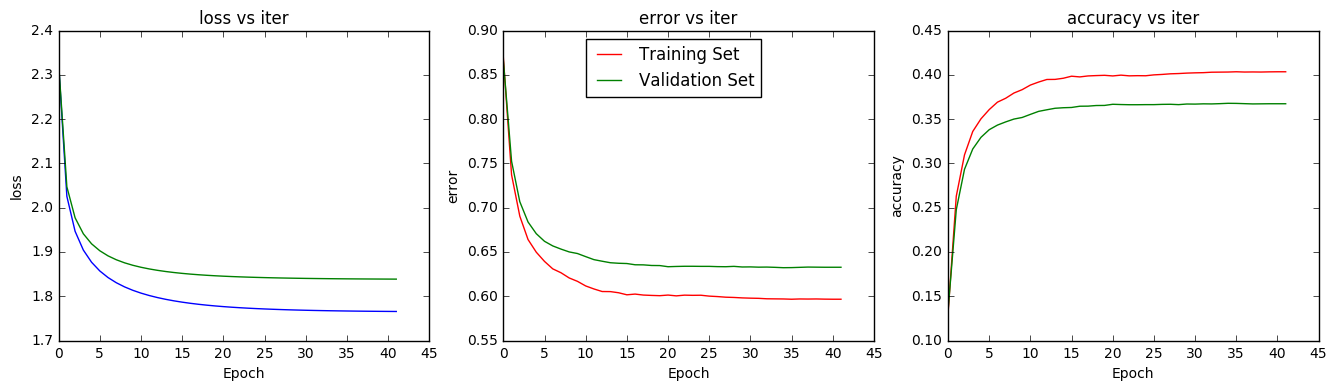

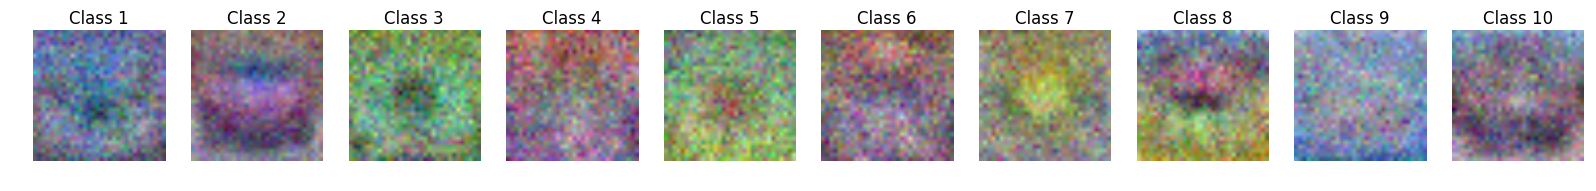

In [131]:
# PCAw,PCAb=weightInt(len(trainingSet),len(trainingSetLabels_hot),'PCA',1)

PCAw,PCAb=wIn,bIn

DropRate='on'
# give parmeters of the minibatch
# lamda, n_epochs, n_batch, eta 
params=GDparams(0.001, 100, 10, 0.01)
EarlyStop='on'
#train the net with minibatch


PCAw, PCAb, lossOnTrain, lossOnValidation, accuracyOnTrain, accuracyOnValidation, BestIter\
            = MiniBatchGD(trainingSet, trainingSetLabels_hot, trainingSetLabels, params, \
                                PCAw, PCAb, validationSet, validationSetLabels, validationSetLabels_hot,'softmax')

# print out learning accuracy
print("The maximum accuracy on train set is: %s"%(np.max(accuracyOnTrain)*100)+"%")
print("The maximum accuracy on validation set is: %s"%(np.max(accuracyOnValidation)*100)+"%"+" at epoch No %s"%BestIter)
# visualize the learing stats
LearningStats(params,lossOnTrain,lossOnValidation,accuracyOnTrain,accuracyOnValidation,'BestApp')

# ## weight visualization
VisWeights(PCAw,params,'BestApp')

In [73]:
### I'm getting memory error in my laptop with this part when runs in jupyter

DropRate='on'
# give parmeters of the minibatch
# lamda, n_epochs, n_batch, eta 
params=GDparams(0.001, 100, 10, 0.01)
EarlyStop='on'
#train the net with minibatch


wBestApp, bBestApp, lossOnTrain, lossOnValidation, accuracyOnTrain, accuracyOnValidation, BestIter\
            = MiniBatchGD(HugetrainingSet, HugetrainingSetLabels_hot, HugetrainingSetLabels, params, \
                                                wIn, bIn, HugevalidationSet, HugevalidationSetLabels, HugevalidationSetLabels_hot)

# print out learning accuracy
print("The maximum accuracy on train set is: %s"%(np.max(accuracyOnTrain)*100)+"%")
print("The maximum accuracy on validation set is: %s"%(np.max(accuracyOnValidation)*100)+"%"+" at epoch No %s"%BestIter)
# visualize the learing stats
LearningStats(params,lossOnTrain,lossOnValidation,accuracyOnTrain,accuracyOnValidation,'BestApp')

# ## weight visualization
VisWeights(wBestApp,params,'HugeBestApp')

MemoryError: 

# Exercise 2 of assingment 1  (SVM)

The maximum accuracy on train set is: 35.82%
The maximum accuracy on validation set is: 31.68% at epoch No 27


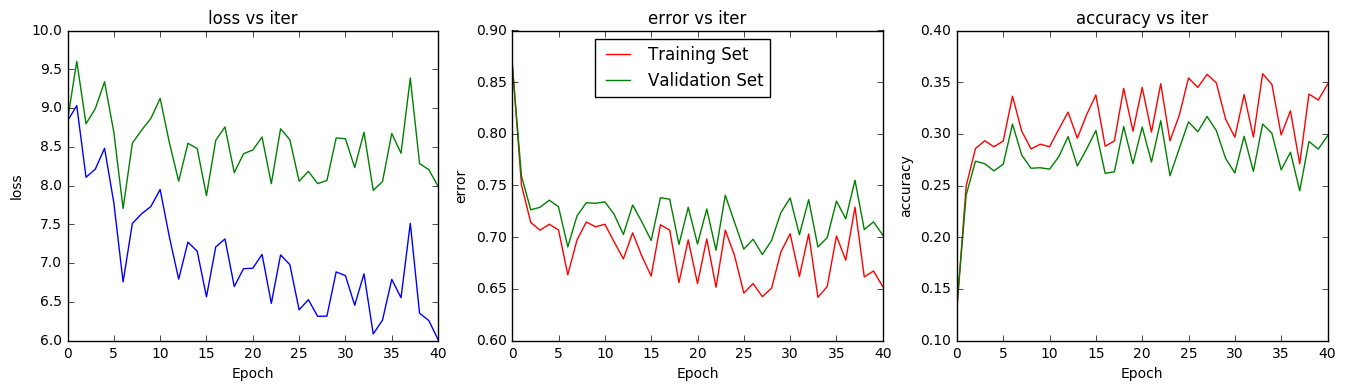

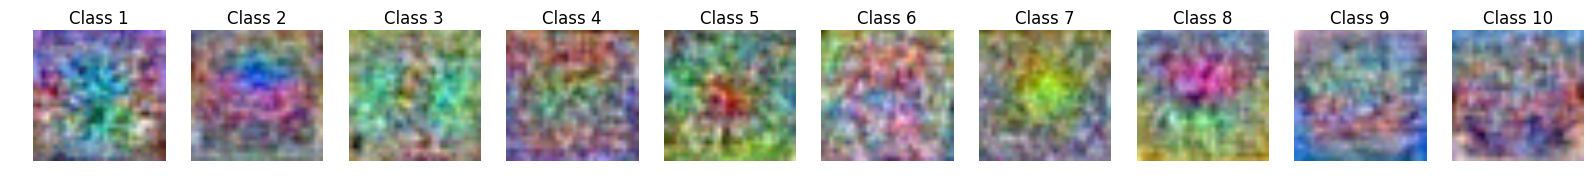

In [133]:
DropRate='off'
# give parmeters of the minibatch
# lamda, n_epochs, n_batch, eta 
params=GDparams(0, 40, 100, 0.01)
EarlyStop='off'
#train the net with minibatch



wSimple, bSimple, lossOnTrain, lossOnValidation, accuracyOnTrain, accuracyOnValidation, BestIter = MiniBatchGD(trainingSet, \
                                                         trainingSetLabels_hot, trainingSetLabels, params, \
                                                            wIn, bIn, validationSet, validationSetLabels, validationSetLabels_hot,\
                                                                                                               'SVM')

# print out learning accuracy
print("The maximum accuracy on train set is: %s"%(np.max(accuracyOnTrain)*100)+"%")
print("The maximum accuracy on validation set is: %s"%(np.max(accuracyOnValidation)*100)+"%"+" at epoch No %s"%BestIter)
# visualize the learing stats
LearningStats(params,lossOnTrain,lossOnValidation,accuracyOnTrain,accuracyOnValidation,'Simple')

# ## weight visualization
VisWeights(wSimple,params,'Simple')

Best example

The maximum accuracy on train set is: 40.6%
The maximum accuracy on validation set is: 35.52% at epoch No 44


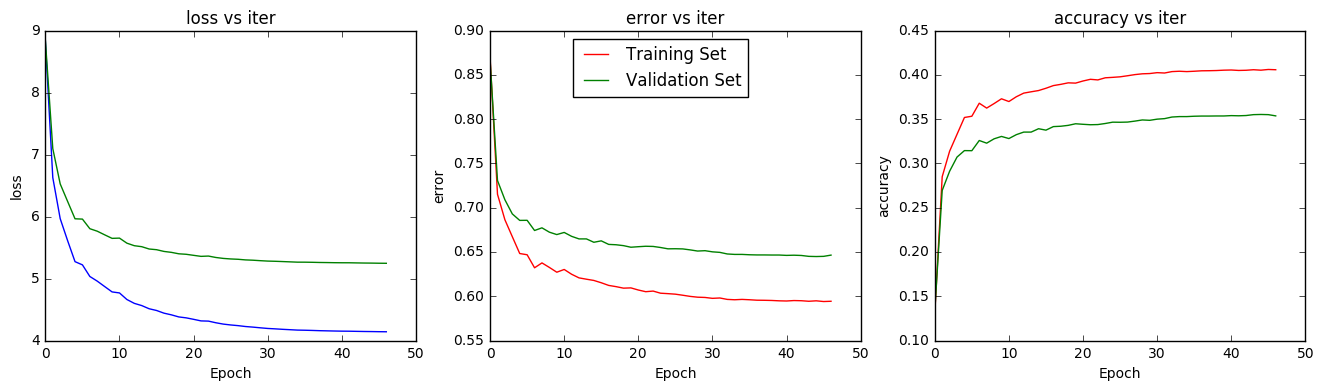

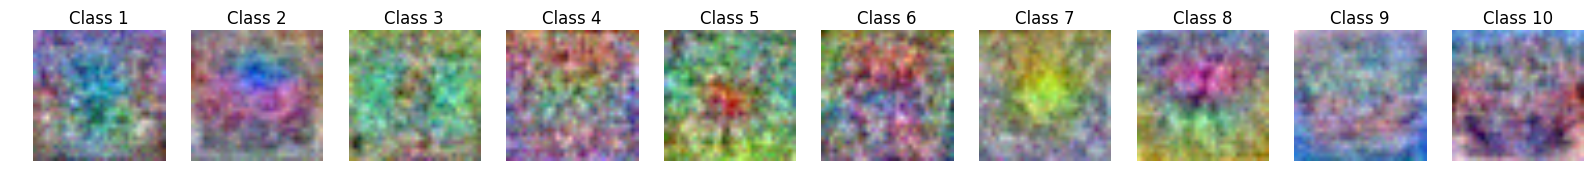

In [141]:
DropRate='on'
# give parmeters of the minibatch
# lamda, n_epochs, n_batch, eta 
params=GDparams(0.001, 100, 10, 0.001)
EarlyStop='on'
#train the net with minibatch



wSimple, bSimple, lossOnTrain, lossOnValidation, accuracyOnTrain, accuracyOnValidation, BestIter = MiniBatchGD(trainingSet, \
                                                         trainingSetLabels_hot, trainingSetLabels, params, \
                                                            wIn, bIn, validationSet, validationSetLabels, validationSetLabels_hot,\
                                                                                                               'SVM')

# print out learning accuracy
print("The maximum accuracy on train set is: %s"%(np.max(accuracyOnTrain)*100)+"%")
print("The maximum accuracy on validation set is: %s"%(np.max(accuracyOnValidation)*100)+"%"+" at epoch No %s"%BestIter)
# visualize the learing stats
LearningStats(params,lossOnTrain,lossOnValidation,accuracyOnTrain,accuracyOnValidation,'Simple')

# ## weight visualization
VisWeights(wSimple,params,'Simple')